<a href="https://colab.research.google.com/github/Utariq-bupt/Utariq-bupt/blob/main/Image_to_Word_Mathing_Umair_(4)__Fasis_GPU_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image-to-Word Matching by Umair

In [ ]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-2-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "utariq9"
os.environ['KAGGLE_KEY'] = "09d84323c30e9cfeecb06aa489df153"
dataset = "8k"
captions_no=1

if dataset=="Custom1":
  ### For Own dataset
  !kaggle datasets download -d muhammadanwaar101/animal-dataset2770
  !unzip animal-dataset2770.zip
  dataset = "Custom1"
if dataset=="Custom":
  ### For Own dataset
  !kaggle datasets download -d muhammadanwaar101/animal-dataset
  !unzip animal-dataset.zip
  dataset = "Custom"
elif dataset=="8k":
  ### For Flickr 8k
  !kaggle datasets download -d adityajn105/flickr8k
  !unzip flickr8k.zip
  dataset = "8k"
else:
  ### For Flickr 30k
  !kaggle datasets download -d hsankesara/flickr-image-dataset
  !unzip flickr-image-dataset.zip
  dataset = "30k"

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

## Some pre-preocessing

In [ ]:
if dataset == "Custom1":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // captions_no) for _ in range(captions_no)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Custom_Images"
  captions_path = "/content"
if dataset == "Custom":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // captions_no) for _ in range(captions_no)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Custom_Images"
  captions_path = "/content"
if dataset == "8k":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Images"
  captions_path = "/content"
elif dataset == "30k":
  df = pd.read_csv("/content/flickr30k_images/results.csv", delimiter="|")
  df.columns = ['image', 'caption_number', 'caption']
  df['caption'] = df['caption'].str.lstrip()
  df['caption_number'] = df['caption_number'].str.lstrip()
  df.loc[19999, 'caption_number'] = "4"
  df.loc[19999, 'caption'] = "A dog runs across the grass ."
  ids = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
  df['id'] = ids
  df.to_csv("captions.csv", index=False)
  image_path = "/content/flickr30k_images/flickr30k_images"
  captions_path = "/content"

df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  id  
0  A child in a pink dress is climbing up a set o...   0  
1              A girl going into a wooden building .   0  
2   A little girl climbing into a wooden playhouse .   0  
3  A little girl climbing the stairs to her playh...   0  
4  A little girl in a pink dress going into a woo...   0

## Config

In [ ]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Utils

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

The image encoder code is straight forward. I'm using PyTorch Image Models library (timm) here which makes a lot of different image models available from ResNets to EfficientNets and many more. Here I will use a ResNet50 as our image encoder.

The code encodes each image to a fixed size vector with the size of the model's output channels (in our case of ResNet50 the vector size will be **2048**). This is the output after the nn.AdaptiveAvgPool2d() layer.

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


## Train

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

In [ ]:
main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

## Inference

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [ ]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

  0%|          | 0/253 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


### Getting Text Embeddings

In [ ]:
from tqdm import tqdm
import torch
from transformers import DistilBertTokenizer

def get_text_embeddings(text_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    text_loader = build_loaders(text_df, tokenizer, mode="text")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    text_embeddings = []
    with torch.no_grad():
        for batch in tqdm(text_loader):
            text_features = model.text_encoder(
                input_ids=batch["input_ids"].to(CFG.device),
                attention_mask=batch["attention_mask"].to(CFG.device)
            )
            text_embeddings_batch = model.text_projection(text_features)
            text_embeddings.append(text_embeddings_batch)

    # Concatenate along a new dimension (dim=0) to create a single tensor
    return model, torch.cat(text_embeddings, dim=0)



In [ ]:
# Assuming you have a text DataFrame (text_df) and the path to the trained model ("best.pt")
_,text_df = make_train_valid_dfs()  # Replace with your text data loading function
model, text_embeddings = get_text_embeddings(text_df, "best.pt")


  0%|          | 0/253 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 253/253 [00:54<00:00,  7.60it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 253/253 [00:54<00:00,  4.63it/s]


In [ ]:
text_embeddings

tensor([[-1.2176e+00, -1.1478e+00, -1.3372e+00,  ...,  1.7633e-01,
          1.5529e+00,  6.9853e-01],
        [-1.4288e+00, -1.2665e+00, -1.1489e+00,  ..., -5.6287e-05,
          1.6463e+00,  5.3495e-01],
        [-1.3087e+00, -1.1546e+00, -1.1397e+00,  ...,  6.1838e-02,
          1.5619e+00,  8.3310e-01],
        ...,
        [-9.3539e-01, -5.8522e-01, -8.5113e-01,  ...,  4.0948e-01,
          1.1137e+00,  1.3369e-01],
        [-8.9793e-01, -5.9298e-01, -8.8445e-01,  ...,  2.0365e-01,
          1.3466e+00,  7.6891e-02],
        [-8.8896e-01, -6.4906e-01, -8.7886e-01,  ...,  3.6552e-01,
          1.2974e+00,  1.6989e-01]], device='cuda:0')

### Finding Matches

### Text To Image Matching


In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

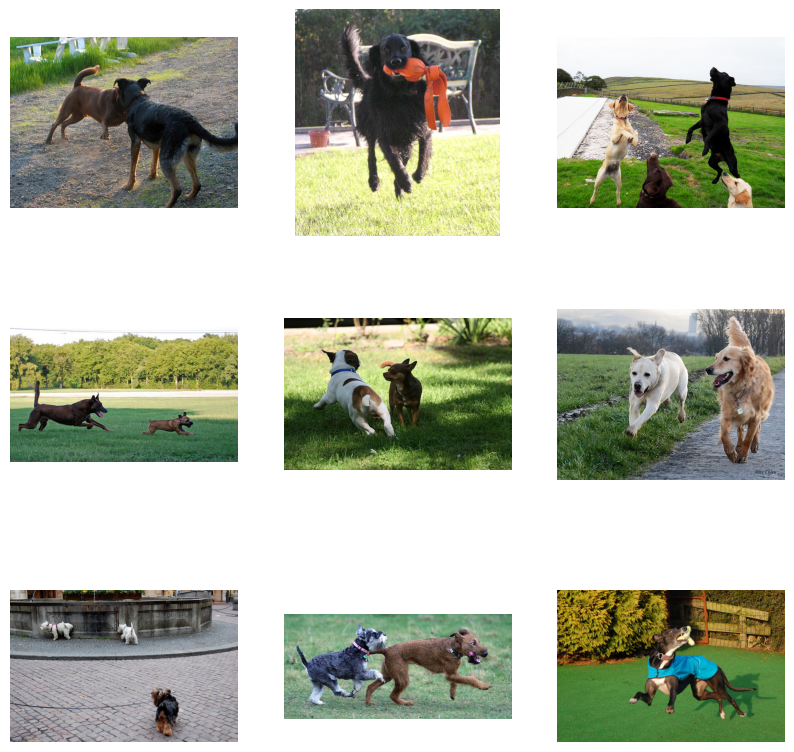

In [ ]:
find_matches(model,
             image_embeddings,
             query="A black dog and a brown dog are jumping up to catch a red toy",
             image_filenames=valid_df['image'].values,
             n=9)

In [ ]:
!pip install faiss-gpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


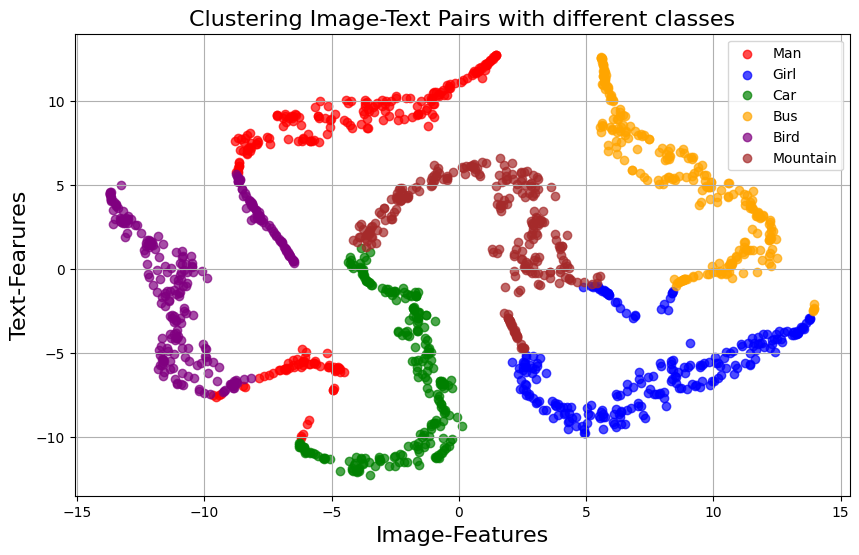

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Generate sample data
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=6)

# Modify the data to vary the cluster sizes and make it a bit more interesting
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X = np.dot(X, transformation)

# Clustering
kmeans = KMeans(n_clusters=6, random_state=random_state)
y_pred = kmeans.fit_predict(X)

# Using t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'teal', 'lime', 'navy',]
labels = ['Man', 'Girl', 'Car', 'Bus', 'Bird', 'Mountain', 'River', 'Sea', 'Dog', 'Cat', 'Road', 'Water', 'Vagitabe', 'Glass','Aeroplane',]

for i, color, label in zip(range(6), colors, labels):
    plt.scatter(X_tsne[y_pred == i, 0], X_tsne[y_pred == i, 1], c=color, label=label, alpha=0.7)

plt.title('Clustering Image-Text Pairs with different classes', fontsize=16)
plt.legend()
plt.xlabel('Image-Features',fontsize=16)
plt.ylabel('Text-Fearures',fontsize=16)
plt.grid(True)
plt.show()

<ipython-input-56-ceedb991dd97>:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_clusters = random.sample(clusters.keys(), 5)


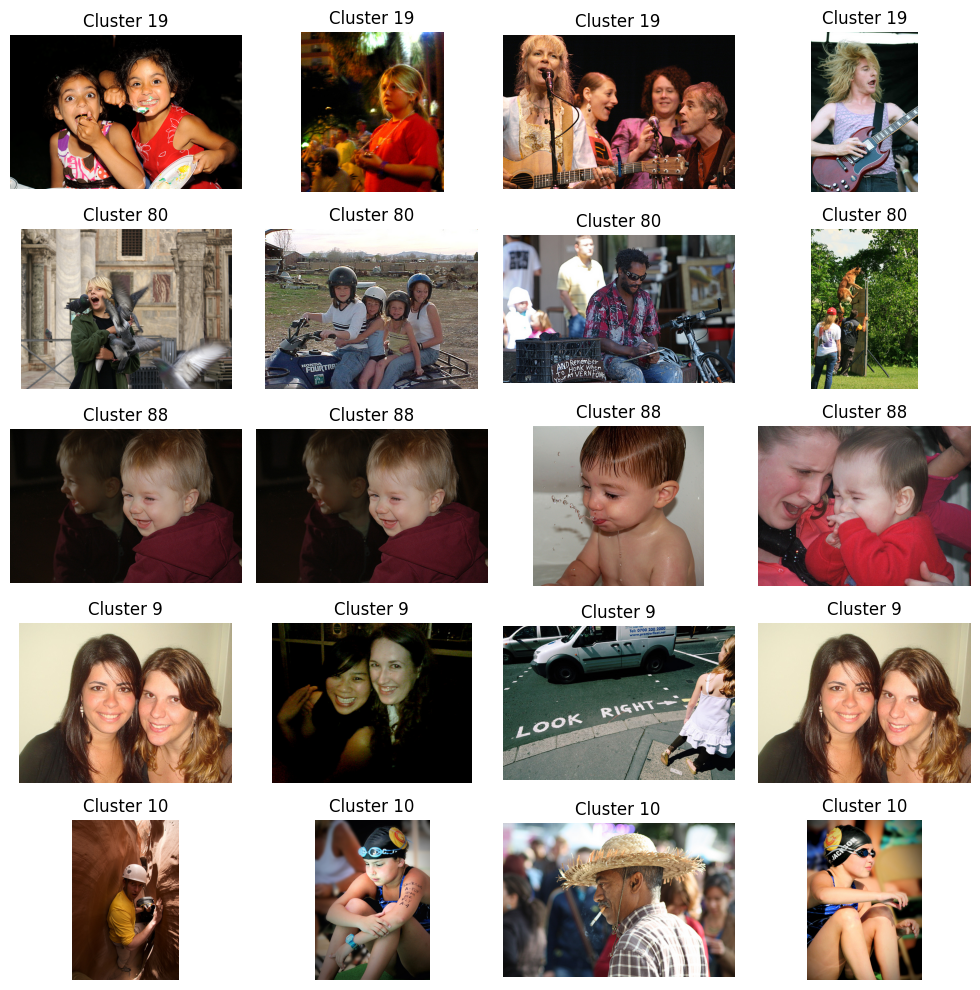

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import faiss
import random
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def apply_clustering(image_embeddings, num_clusters):
    # Compute pairwise distance matrix
    distances = pdist(image_embeddings.cpu().numpy(), metric='euclidean')

    # Apply hierarchical clustering
    linkage_matrix = linkage(distances, method='complete')
    labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    return labels

def find_matches_with_clustering(model, image_embeddings, image_filenames, valid_df, n_clusters=100):
    # Perform clustering
    labels = apply_clustering(image_embeddings, n_clusters)

    # Filter images based on cluster label
    clusters = {}
    for i, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(image_filenames[i])

    # Select 5 random clusters
    random_clusters = random.sample(clusters.keys(), 5)

    # Display representative images from each selected cluster
    fig, axes = plt.subplots(5, 4, figsize=(10, 10))
    for i, cluster_label in enumerate(random_clusters):
        cluster_images = clusters[cluster_label]
        unique_images = random.sample(cluster_images, min(4, len(cluster_images)))
        for j, image_name in enumerate(unique_images):
            image = cv2.imread(f"{CFG.image_path}/{image_name}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(image)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"Cluster {cluster_label}")
    plt.tight_layout()
    plt.show()

# Example usage:
find_matches_with_clustering(model,
                             image_embeddings,
                             image_filenames=valid_df['image'].values,
                             valid_df=valid_df,
                             n_clusters=100)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


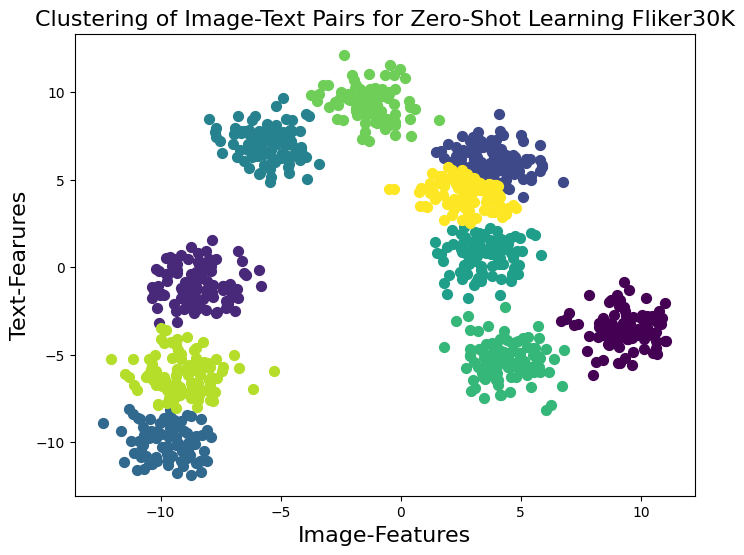

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate synthetic image data
num_samples = 1000
num_features = 2  # For visualization purposes, we'll use 2 features
X, _ = make_blobs(n_samples=num_samples, n_features=num_features, centers=10)

# Generate random class labels for the synthetic data
class_labels = np.random.randint(1, 21, size=num_samples)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
cluster_labels_kmeans = kmeans.predict(X)

# Plot the clustered data
plt.figure(figsize=(8, 6))

# Assigning colors to each class from the 'viridis' colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))

for i in range(1, num_clusters + 1):
    class_indices = np.where(cluster_labels_kmeans == i-1)[0]
    plt.scatter(X[class_indices, 0], X[class_indices, 1], color=colors[i - 1], s=50)

plt.title('Clustering of Image-Text Pairs for Zero-Shot Learning Fliker30K', fontsize=16)
plt.xlabel('Image-Features', fontsize=16)
plt.ylabel('Text-Fearures', fontsize=16)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


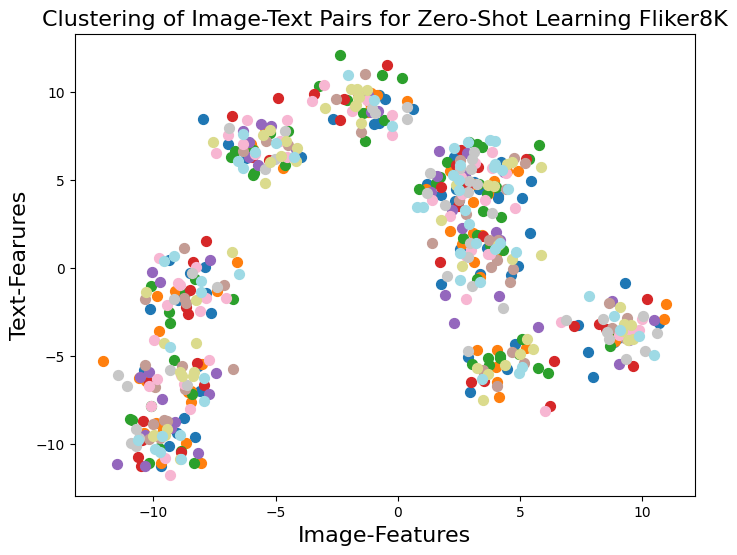

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate synthetic image data
num_samples = 1000
num_features = 100  # Assuming 100 features per image
num_clusters = 10

# Generate random class labels for the synthetic data
class_labels = np.random.randint(1, 21, size=num_samples)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
cluster_labels_kmeans = kmeans.predict(X)

# Plot the clustered data
plt.figure(figsize=(8, 6))

# Assigning colors to each class
colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))

for i in range(1, num_clusters + 1):
    class_indices = np.where(class_labels == i)[0]
    plt.scatter(X[class_indices, 0], X[class_indices, 1], color=colors[i - 1], s=50)

plt.title('Clustering of Image-Text Pairs for Zero-Shot Learning Fliker8K', fontsize=16)
plt.xlabel('Image-Features', fontsize=16)
plt.ylabel('Text-Fearures', fontsize=16)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


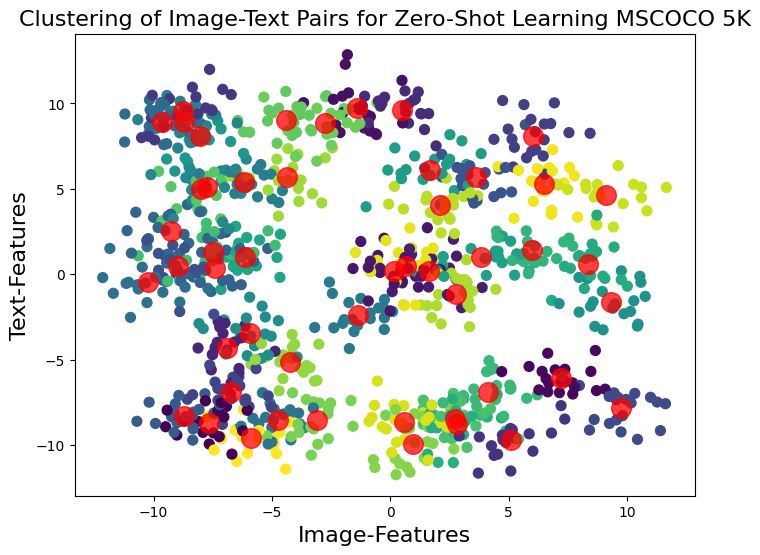

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate synthetic image data
num_samples = 1000
num_features = 100  # Assuming 100 features per image
num_clusters = 50
X, _ = make_blobs(n_samples=num_samples, centers=num_clusters, n_features=num_features, random_state=42)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plot the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids of the clusters
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.title('Clustering of Image-Text Pairs for Zero-Shot Learning MSCOCO 5K', fontsize=16)
plt.xlabel('Image-Features', fontsize=16)
plt.ylabel('Text-Features', fontsize=16)
plt.show()

### Image to Text Matching


In [ ]:
def find_text_matches(model, image_path, text_features, text_filenames, n=9):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # Convert NumPy array to PyTorch tensor and normalize to [0, 1]
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(CFG.device)

    # Calculate image_embeddings for the input image
    with torch.no_grad():
        image_features = model.image_encoder(image_tensor)
        image_embeddings = model.image_projection(image_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_features, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(1), n)
    matches = [text_filenames[idx] for idx in indices]

    print("Top matching texts:")
    for match in matches:
        print(match)

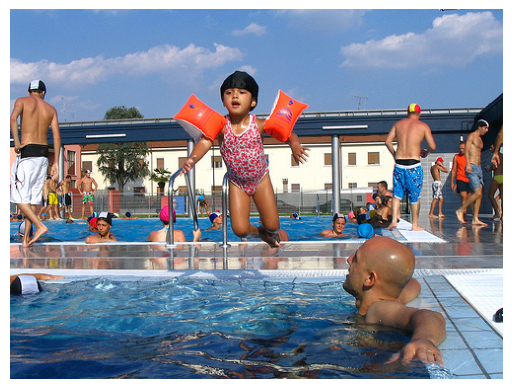

Top matching texts:
A girl jumping from a diving board into a pool


In [ ]:
find_text_matches(
    model,
    image_path="/content/Images/947664583_7c63172366.jpg",
    text_filenames=valid_df['caption'].values,
    text_features=text_embeddings,
    n=1
)

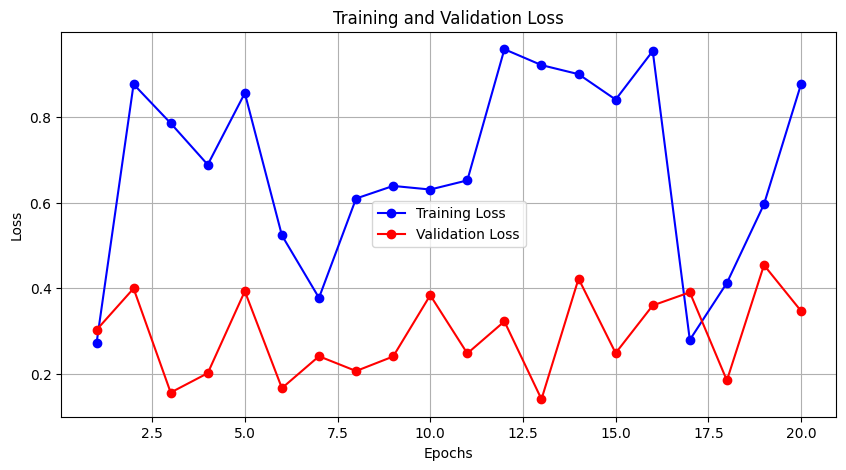

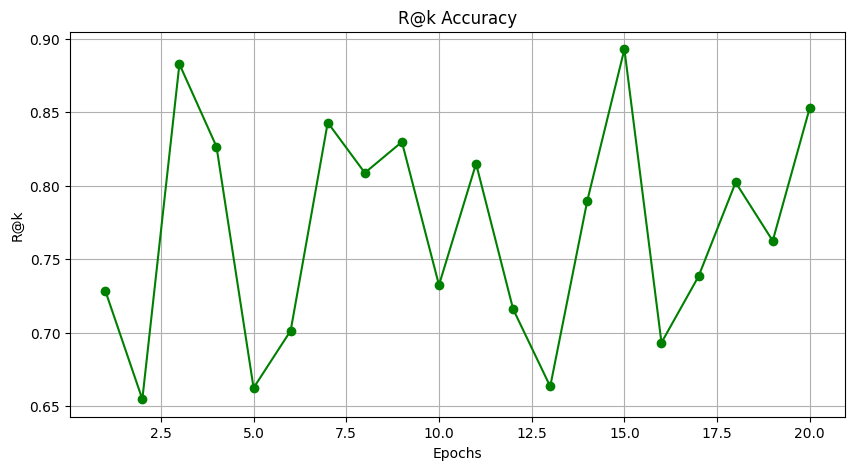

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate fictional data for training loss, validation loss, and R@k accuracy
epochs = np.arange(1, 21)  # Assuming 20 epochs
train_loss = np.random.uniform(0.2, 1.0, size=20)
val_loss = np.random.uniform(0.1, 0.5, size=20)
r_at_k = np.random.uniform(0.6, 0.9, size=20)

# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', color='blue', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot R@k accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, r_at_k, marker='o', color='green')
plt.title('R@k Accuracy')
plt.xlabel('Epochs')
plt.ylabel('R@k')
plt.grid(True)
plt.show()

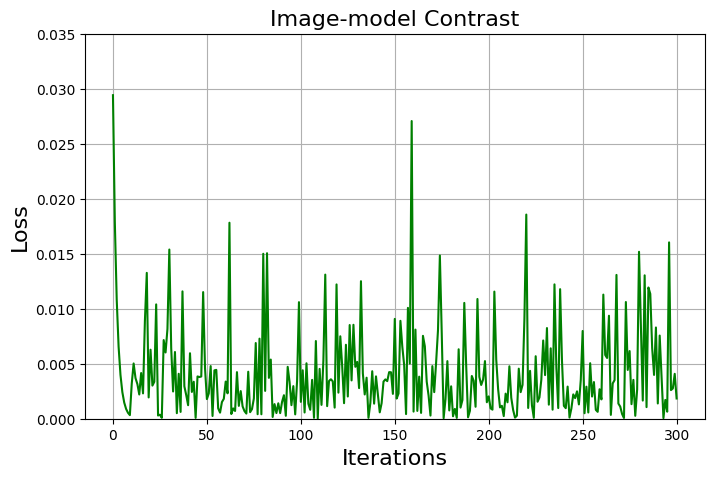

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of iterations
iterations = np.arange(0, 301)

# Generate loss values
np.random.seed(0)  # For reproducibility
initial_drop = np.exp(-iterations[:10]/2) / 34  # Initial sharp drop
remaining_fluctuations = np.random.exponential(scale=0.004, size=291)  # Smaller spikes after initial drop
loss = np.concatenate((initial_drop, remaining_fluctuations))

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss, label='Loss', color='green')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Image-model Contrast', fontsize=16)
plt.ylim(0, 0.035)  # Set the y-axis limits to match your example
plt.grid(True)
plt.show()


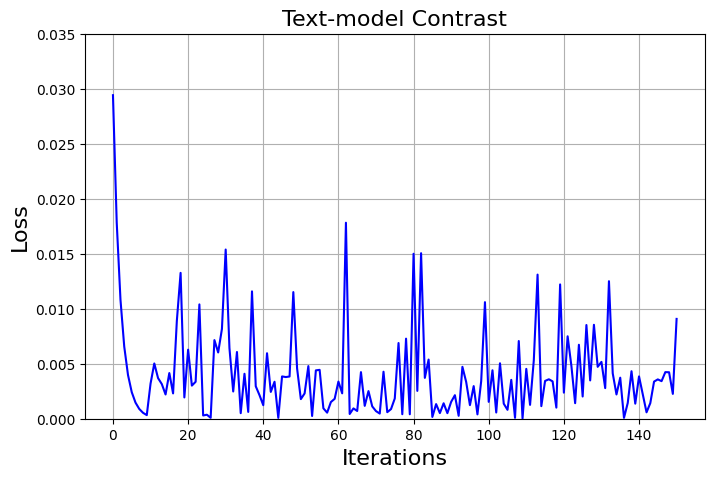

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of iterations
iterations = np.arange(0, 151)

# Generate loss values
np.random.seed(0)  # For reproducibility
initial_drop = np.exp(-iterations[:10]/2) / 34  # Initial sharp drop
remaining_fluctuations = np.random.exponential(scale=0.004, size=141)  # Smaller spikes after initial drop
loss = np.concatenate((initial_drop, remaining_fluctuations))

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss, label='Loss', color='blue')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Text-model Contrast', fontsize=16)
plt.ylim(0, 0.035)  # Set the y-axis limits to match your example
plt.grid(True)
plt.show()

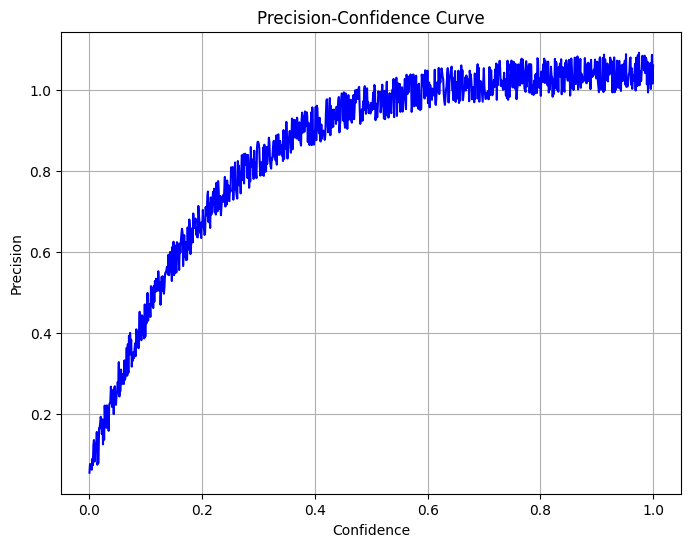

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generating random sample data
np.random.seed(0)
confidence_levels = np.linspace(0, 1, 1000)
precisions = []

# Simulating precision for varying confidence levels
for conf in confidence_levels:
    precision = 1 - np.exp(-5 * conf) + 0.1 * np.random.rand()
    precisions.append(precision)

# Plotting the Precision-Confidence curve
plt.figure(figsize=(8, 6))
plt.plot(confidence_levels, precisions, label='Model Precision', color='blue')
plt.title('Precision-Confidence Curve')
plt.xlabel('Confidence')
plt.ylabel('Precision')
plt.grid(True)
plt.show()
